In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
from pandarallel import pandarallel

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [1]:
ab = '../../lr_bulk/talon/human_talon_abundance.tsv'
filt_ab = '../../lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
read_annot = '../../lr_bulk/talon/human_talon_read_annot.tsv'
t_metadata = '../../refs/cerberus/v40_transcript_metadata.tsv'
t_orig_metadata = '../../refs/v40_transcript_metadata.tsv'
swan_file = '../../lr_bulk/cerberus/swan/swan_meta.p'
cerberus_h5 = '../../lr_bulk/cerberus/triplets/cerberus_annot_triplets.h5'
major_isos = '../../lr_bulk/cerberus/swan/major_isos.tsv'
mane_file = '../../refs/v40_gene_metadata.tsv'

ver = 'v40_cerberus'

min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'

mouse_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance.tsv'
mouse_filt_ab = '../../mouse/lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
mouse_read_annot = '../../mouse/lr_bulk/talon/mouse_talon_read_annot.tsv'
mouse_swan_file = '../../mouse/lr_bulk/swan/swan.p'
mouse_meta = '../../mouse/lr_bulk/lr_mouse_library_data_summary.tsv'
mouse_t_metadata = '../../mouse/refs/cerberus/vM25_transcript_metadata.tsv'
mouse_ver = 'vM25_cerberus'
mouse_h5 = '../../mouse/lr_bulk/triplets/cerberus_annot_triplets.h5'

orth_table = '../../refs/biomart_human_to_mouse.tsv'

In [32]:
def plot_human_mouse_simplex(ca, m_ca, h_gene, m_gene, odir):
    

    # human
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_mm_det': '^', 'cerberus': '2', 'sample_mm_det_centroid': 'x'} 
    subset = {'source': ['v40', 'obs_mm_det', 'sample_mm_det', 'sample_mm_det_centroid']}
    
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=h_gene,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                size_scale=0.5,
                fname='{}/simplex_{}.pdf'.format(odir, h_gene.lower()))

    # mouse
    c_dict, order = get_lr_bulk_sample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'vM25': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2', 'sample_det_mouse_centroid': 'x'} 
    subset = {'source': ['vM25', 'obs_det', 'sample_det_mouse', 'sample_det_mouse_centroid']}
    df = m_ca.plot_simplex(top='splicing_ratio', 
                gene=m_gene,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                size_scale=0.5,
                fname='{}/simplex_mouse_{}.pdf'.format(odir, m_gene.lower()))

## Human vs mouse sector sankey

In [ ]:
# major isoform triplets mouse match 
h_source = 'obs_mm_major'
m_source = 'obs_major'

df = human_v_mouse_sectors(cerberus_h5,
                      mouse_h5,
                      h_source,
                      m_source,
                      gene_subset=[gene_subset],
                      ofile='figures/obs_major_mouse_v_human_triplets_sankey.pdf')

## Simplex plots for human and mouse ARF4 / Arf4

In [19]:
# restrict sample triplets to mm ones
ca = cerberus.read(cerberus_h5)
samples = get_mouse_match_samples()
inds = ca.triplets.loc[(ca.triplets.source == 'sample_det')&\
                       ~(ca.triplets['sample'].isin(samples))].index
ca.triplets.drop(inds, axis=0, inplace=True)
ca.triplets.loc[ca.triplets.source == 'sample_det', 'source'] = 'sample_mm_det'
ca = get_centroids(ca, 
                   source='sample_mm_det',
                   gene_subset=gene_subset,
                   ver=ver)

# add suffix to mouse sources
m_ca = cerberus.read(mouse_h5)
m_ca.triplets.loc[m_ca.triplets.source == 'sample_det', 'source'] ='sample_det_mouse'
m_ca = get_centroids(m_ca,
                     source='sample_det_mouse',
                     gene_subset=gene_subset,
                     ver=mouse_ver)

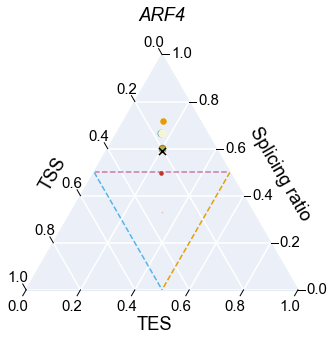

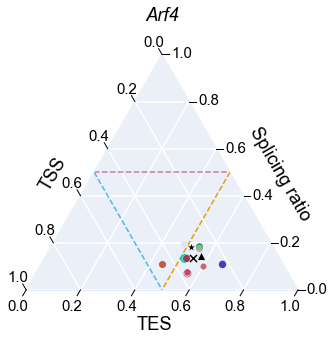

In [33]:
plot_human_mouse_simplex(ca, m_ca, 'ARF4', 'Arf4', 'figures/')

In [4]:
# merge in gids for orthologs
def get_human_mouse_gid_table(fname):
    # get matching gids from human and mouse
    df = pd.read_csv(fname, sep='\t')

    # drop nans in either human or mouse
    df = df[['Gene stable ID', 'Mouse gene stable ID']]
    df = df.loc[~df['Gene stable ID'].isnull()]
    df = df.loc[~df['Mouse gene stable ID'].isnull()]    
    
    df = df.drop_duplicates()
    return df

In [5]:
hm_gids = get_human_mouse_gid_table(orth_table)

In [6]:
# merge in mouse gids that we need
ca.triplets = ca.triplets.merge(hm_gids, how='inner', left_on='gid', right_on='Gene stable ID')

# merge in mouse data
m_ca.triplets = m_ca.triplets.merge(hm_gids, how='inner', left_on='gid', right_on='Mouse gene stable ID')

In [7]:
# concatenate the dfs
ca.triplets = pd.concat([ca.triplets, m_ca.triplets], axis=0)

In [10]:
df = compute_dists(ca, 'sample_mm_det_centroid', \
                   'sample_det_mouse_centroid', \
                   gene_merge=['Gene stable ID'])

In [15]:
df.loc[df.gname_sample_mm_det_centroid == 'ARF4']

,source_sample_mm_det_centroid,gid_sample_mm_det_centroid,n_tss_sample_mm_det_centroid,n_tes_sample_mm_det_centroid,n_ic_sample_mm_det_centroid,n_iso_sample_mm_det_centroid,splicing_ratio_sample_mm_det_centroid,tss_ratio_sample_mm_det_centroid,tes_ratio_sample_mm_det_centroid,spl_ratio_sample_mm_det_centroid,...,spl_ratio_sample_det_mouse_centroid,sector_sample_det_mouse_centroid,gname_sample_det_mouse_centroid,sample_sample_det_mouse_centroid,gene_tpm_sample_det_mouse_centroid,Mouse gene stable ID_sample_det_mouse_centroid,tissue_sample_det_mouse_centroid,tissue_adult_sample_det_mouse_centroid,dist,z_score
18586,sample_mm_det_centroid,ENSG00000168374,1.0,1.0,3.111111,3.111111,3.111111,0.206614,0.206614,0.586772,...,0.136259,tes,Arf4,NaN,NaN,ENSMUSG00000021877,NaN,NaN,0.348437,3.884851
